In [1]:
# import libraries
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# define parameters
LINE_POINT_DIST_THRESHOLD = 0.15
MIN_POINTS_PER_SEGMENT = 10
MIN_SEG_LENGTH = 0.7
MAX_P2P_DIST = 0.25

In [4]:
# define functions
def split_and_merge(range_data, LINE_POINT_DIST_THRESHOLD, MIN_POINTS_PER_SEGMENT, MIN_SEG_LENGTH, MAX_P2P_DIST):
    # convert polar to cartesian
    theta = range_data[:, 0]
    rho = range_data[:, 1]
    x = rho * np.cos(theta)
    y = rho * np.sin(theta)
    points = np.vstack((x, y)).T

    # recursive function
    max_depth = 100
    def recursive_split(points, depth):
        if len(points) < MIN_POINTS_PER_SEGMENT or depth > max_depth:
            return [points]

        # line fit
        coeff = np.polyfit(points[:, 0], points[:, 1], 1)
        line_func = lambda x: coeff[0] * x + coeff[1]

        # calculate distances
        distances = np.abs(points[:, 1] - line_func(points[:, 0])) / np.sqrt(1 + coeff[0]**2)
        max_dist = np.max(distances)
        max_idx = np.argmax(distances)

        if max_dist > LINE_POINT_DIST_THRESHOLD and 1 < max_idx < len(points) - 1:
            print(f'Splitting at depth {depth}, maxDist = {max_dist:.4f}')
            segments1 = recursive_split(points[:max_idx+1], depth + 1)
            segments2 = recursive_split(points[max_idx:], depth + 1)
            return segments1 + segments2
        else:
            return [points]

    # split
    raw_segments = recursive_split(points, 0)

    # filter & merge
    lines = []
    for seg in raw_segments:
        if len(seg) < MIN_POINTS_PER_SEGMENT or np.linalg.norm(seg[-1] - seg[0]) < MIN_SEG_LENGTH:
            continue
        lines.append(seg)
    return lines

In [5]:
# plotting
def plot_segments(lines, title_text):
    plt.figure()
    for seg in lines:
        plt.plot(seg[:, 0], seg[:, 1], '-o')
    plt.title(title_text)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.axis('equal')
    plt.show()

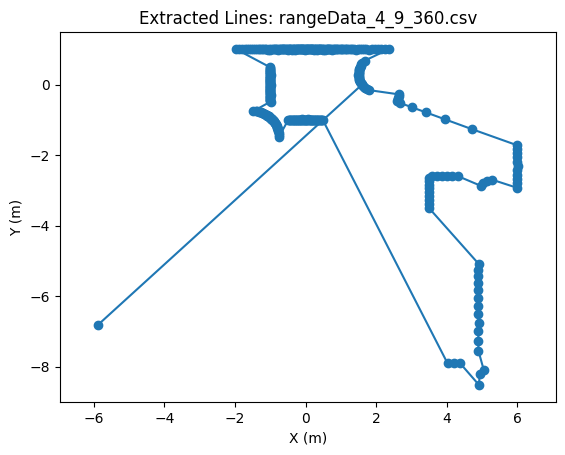

Splitting at depth 0, maxDist = 5.4816


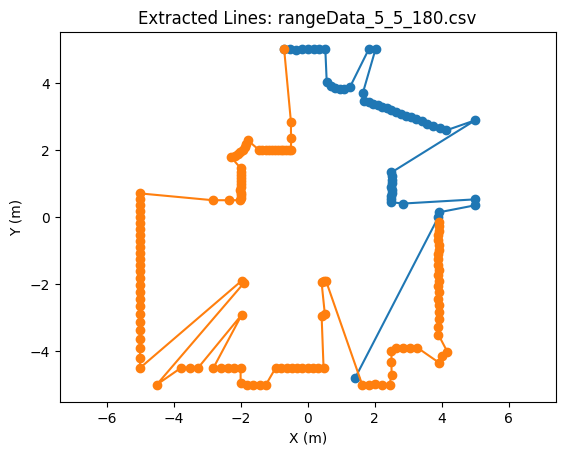

Splitting at depth 0, maxDist = 6.8521
Splitting at depth 1, maxDist = 1.0657
Splitting at depth 2, maxDist = 0.8460


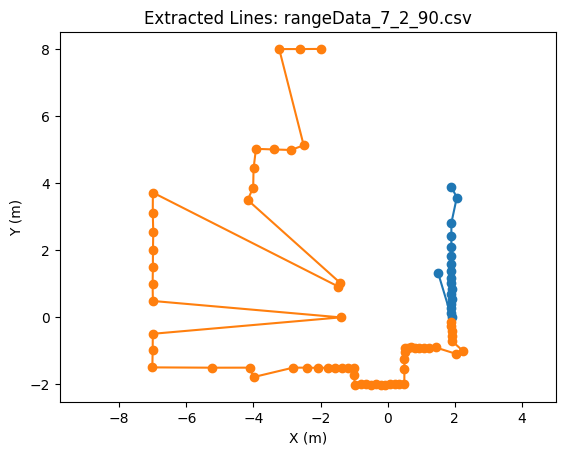

In [6]:
# main function
datasets = ['rangeData_4_9_360.csv', 'rangeData_5_5_180.csv', 'rangeData_7_2_90.csv']
for dataset in datasets:
    file_path = f'/content/drive/My Drive/{dataset}'
    range_data = pd.read_csv(file_path, header=None).values
    lines = split_and_merge(range_data, LINE_POINT_DIST_THRESHOLD, MIN_POINTS_PER_SEGMENT, MIN_SEG_LENGTH, MAX_P2P_DIST)
    plot_segments(lines, f'Extracted Lines: {dataset}')

In [7]:
# Unmount Google Drive
drive.flush_and_unmount()